In [176]:
from sklearn.metrics import precision_score, recall_score, precision_recall_curve,f1_score, fbeta_score
from sklearn.metrics import roc_auc_score, roc_curve

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('default')
%matplotlib inline
import numpy as np

# Table of Contents
1) Intro

2) Loading and Final Engineering 
    
    2.1) Choosing Target Class
    2.2) EDA

3) Modeling

    3.1) "Dumb" Model
    3.2) Logistic Regression
    3.3) K Nearest Neighbor 
    3.4) Decision Tree
    3.5) Random Forest
    3.6) XG Boost

# 1 - Intro
I am using car crash data in New York State over a 3 year period to predict the chance of a crash being simple property damage vs an injury/fatality. Below is my finalizing my target class (picking between Fatality vs No Fatality and Damage vs Injury Fatality) and my models ranging from the simple model that predicts property damage each time to XG Boost. Each model features a normal threshold (.5) and slightly revised threshold scores based on the results of the ROC Curve. Each model is also accompanied by a confusion matrix.

# 2 - Loading and Final Engineering

In [2]:
df_sample = pd.read_csv('crash_fixed.csv') 

In [3]:
df_sample.drop(['Unnamed: 0'] ,axis=1, inplace=True)

In [4]:
df_sample.head()

,Crash Descriptor,Police Report,Traffic Control Device,Number of Vehicles Involved,Population Density,Pop per DUI,Time,Month,Day of Week,Precipitation?,...,County Name_SULLIVAN,County Name_TIOGA,County Name_TOMPKINS,County Name_ULSTER,County Name_WARREN,County Name_WASHINGTON,County Name_WAYNE,County Name_WESTCHESTER,County Name_WYOMING,County Name_YATES
0,Property Damage Accident,1,1,2,20553,5579,11,12,6,1,...,0,0,0,0,0,0,0,0,0,0
1,Injury Accident,1,1,1,69464,6594,18,12,6,1,...,0,0,0,0,0,0,0,0,0,0
2,Property Damage Accident,1,0,1,213,1261,14,12,6,1,...,0,0,1,0,0,0,0,0,0,0
3,Property Damage Accident,1,0,1,881,1438,12,12,6,0,...,0,0,0,0,0,0,0,0,0,0
4,Property Damage & Injury Accident,1,1,2,69464,6594,15,12,6,1,...,0,0,0,0,0,0,0,0,0,0


### 2.1 - Choosing my minority class:


#### Trying out Fatalaties

In [5]:
df_sample['Crash Descriptor'].value_counts()

Property Damage Accident             536288
Injury Accident                      183049
Property Damage & Injury Accident    171334
Fatal Accident                         2986
Name: Crash Descriptor, dtype: int64

In [6]:
df_sample['Fatalaty?'] = df_sample['Crash Descriptor'].str.contains('Fatal').astype(int)


In [7]:
def bar_convert(x):
    if x == 0:
        return 'Non-Fatal'
    else:
        return 'Fatal'

In [8]:
df_sample['Fatalaty?'] = df_sample['Fatalaty?'].apply(bar_convert)

In [9]:
df_sample['Fatalaty?'].value_counts()

Non-Fatal    890671
Fatal          2986
Name: Fatalaty?, dtype: int64

Text(0.5, 1.0, 'Severe Imbalance Between \n Non-Fatal and Fatal Accidents in Data')

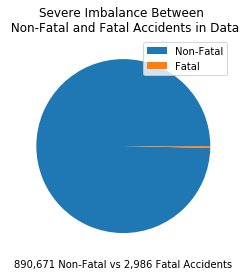

In [10]:
df_sample['Fatalaty?'].value_counts().plot(kind='pie',labels=None).legend(["Non-Fatal", "Fatal"]);
plt.xlabel('890,671 Non-Fatal vs 2,986 Fatal Accidents')
plt.ylabel('')
plt.title('Severe Imbalance Between \n Non-Fatal and Fatal Accidents in Data')
#plt.savefig('severe_imbalance.jpg')

Ultimately this imbalance is too severe, especially given the lack of drinking and driving related metrics for these accidents as DUIs account for a large number of traffic fatalaties.

In [11]:
df_sample.drop(['Fatalaty?'] ,axis=1, inplace=True)

#### Switching to Injuries and Finalizing 

In [12]:
df = df_sample.copy()

In [13]:
df['Crash Descriptor'] = df['Crash Descriptor'].str.contains('Injury'or'Fatal').astype(int)

In [14]:
df.rename(columns={'Crash Descriptor': 'Injury/Fatality?'}, inplace=True)

In [15]:
df['Injury/Fatality?'].value_counts()

0    539274
1    354383
Name: Injury/Fatality?, dtype: int64

Text(0.5, 1.0, 'Balance Between Property Damage \nand Injury/Fatal Accidents in Data')

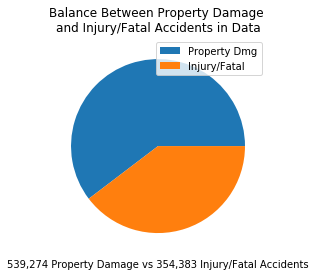

In [251]:
df['Injury/Fatality?'].value_counts().plot(kind='pie',labels=None).legend(["Property Dmg", "Injury/Fatal"]);
plt.xlabel('539,274 Property Damage vs 354,383 Injury/Fatal Accidents')
plt.ylabel('')
plt.title('Balance Between Property Damage \nand Injury/Fatal Accidents in Data')
# plt.savefig('balance.jpg')

In [17]:
df.head()

,Injury/Fatality?,Police Report,Traffic Control Device,Number of Vehicles Involved,Population Density,Pop per DUI,Time,Month,Day of Week,Precipitation?,...,County Name_SULLIVAN,County Name_TIOGA,County Name_TOMPKINS,County Name_ULSTER,County Name_WARREN,County Name_WASHINGTON,County Name_WAYNE,County Name_WESTCHESTER,County Name_WYOMING,County Name_YATES
0,0,1,1,2,20553,5579,11,12,6,1,...,0,0,0,0,0,0,0,0,0,0
1,1,1,1,1,69464,6594,18,12,6,1,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,1,213,1261,14,12,6,1,...,0,0,1,0,0,0,0,0,0,0
3,0,1,0,1,881,1438,12,12,6,0,...,0,0,0,0,0,0,0,0,0,0
4,1,1,1,2,69464,6594,15,12,6,1,...,0,0,0,0,0,0,0,0,0,0


### 2.2 - EDA (Heat Map for Non County Features!)

In [18]:
df.columns

Index(['Injury/Fatality?', 'Police Report', 'Traffic Control Device',
       'Number of Vehicles Involved', 'Population Density', 'Pop per DUI',
       'Time', 'Month', 'Day of Week', 'Precipitation?', 'Daylight?',
       'Lit Dark Road?', 'Twilight Hour?', 'Straight Road?', 'Level Road?',
       'Hill Crest?', 'Dry Road?', 'Collision?', 'Pedestrian',
       'Other Vehicle?', 'Cyclist?', 'Fixed Object?', 'Unkown Cause',
       'Explosion/Fire', 'Animal Involved?', 'Overturned?', 'Train?',
       'Submerged Car?', 'County Name_ALBANY', 'County Name_ALLEGANY',
       'County Name_BRONX', 'County Name_BROOME', 'County Name_CATTARAUGUS',
       'County Name_CAYUGA', 'County Name_CHAUTAUQUA', 'County Name_CHEMUNG',
       'County Name_CHENANGO', 'County Name_CLINTON', 'County Name_COLUMBIA',
       'County Name_CORTLAND', 'County Name_DELAWARE', 'County Name_DUTCHESS',
       'County Name_ERIE', 'County Name_ESSEX', 'County Name_FRANKLIN',
       'County Name_FULTON', 'County Name_GENESEE',

In [139]:
heat = df.drop(['Pop per DUI','County Name_ALBANY',
       'County Name_ALLEGANY', 'County Name_BRONX', 'County Name_BROOME',
       'County Name_CATTARAUGUS', 'County Name_CAYUGA',
       'County Name_CHAUTAUQUA', 'County Name_CHEMUNG', 'County Name_CHENANGO',
       'County Name_CLINTON', 'County Name_COLUMBIA', 'County Name_CORTLAND',
       'County Name_DELAWARE', 'County Name_DUTCHESS', 'County Name_ERIE',
       'County Name_ESSEX', 'County Name_FRANKLIN', 'County Name_FULTON',
       'County Name_GENESEE', 'County Name_GREENE', 'County Name_HAMILTON',
       'County Name_HERKIMER', 'County Name_JEFFERSON', 'County Name_KINGS',
       'County Name_LEWIS', 'County Name_LIVINGSTON', 'County Name_MADISON',
       'County Name_MONROE', 'County Name_MONTGOMERY', 'County Name_NASSAU',
       'County Name_NEW YORK', 'County Name_NIAGARA', 'County Name_ONEIDA',
       'County Name_ONONDAGA', 'County Name_ONTARIO', 'County Name_ORANGE',
       'County Name_ORLEANS', 'County Name_OSWEGO', 'County Name_OTSEGO',
       'County Name_PUTNAM', 'County Name_QUEENS', 'County Name_RENSSELAER',
       'County Name_RICHMOND', 'County Name_ROCKLAND', 'County Name_SARATOGA',
       'County Name_SCHENECTADY', 'County Name_SCHOHARIE',
       'County Name_SCHUYLER', 'County Name_SENECA', 'County Name_ST LAWRENCE',
       'County Name_STEUBEN', 'County Name_SUFFOLK', 'County Name_SULLIVAN',
       'County Name_TIOGA', 'County Name_TOMPKINS', 'County Name_ULSTER',
       'County Name_WARREN', 'County Name_WASHINGTON', 'County Name_WAYNE',
       'County Name_WESTCHESTER', 'County Name_WYOMING', 'County Name_YATES'] ,axis=1)

In [140]:
heat.corr()

,Injury/Fatality?,Police Report,Traffic Control Device,Number of Vehicles Involved,Population Density,Time,Month,Day of Week,Precipitation?,Daylight?,...,Pedestrian,Other Vehicle?,Cyclist?,Fixed Object?,Unkown Cause,Explosion/Fire,Animal Involved?,Overturned?,Train?,Submerged Car?
Injury/Fatality?,1.000000,0.135779,0.118264,0.072787,0.268635,0.069633,0.025269,0.002749,0.060635,0.053378,...,0.262810,0.008112,0.168242,-0.057420,0.002059,-0.023811,-0.066589,0.035797,0.000979,-0.005685
Police Report,0.135779,1.000000,-0.219358,0.010157,-0.186912,0.166796,0.016858,0.000522,0.348706,0.248293,...,0.068047,-0.032749,0.042377,0.059217,-0.032305,0.007354,0.005867,0.019864,0.002336,-0.010523
Traffic Control Device,0.118264,-0.219358,1.000000,0.087055,0.151049,-0.015946,0.001633,-0.014210,-0.137833,-0.054910,...,0.048756,0.141114,0.038421,-0.143536,0.012796,-0.018415,-0.047936,-0.023064,0.006074,-0.000523
Number of Vehicles Involved,0.072787,0.010157,0.087055,1.000000,0.074362,0.031359,-0.002897,-0.032048,0.061063,0.163605,...,-0.262759,0.805413,-0.167111,-0.476660,-0.004614,-0.039687,-0.118506,-0.075940,-0.007594,-0.015694
Population Density,0.268635,-0.186912,0.151049,0.074362,1.000000,-0.013088,0.012908,0.008560,-0.037516,-0.072753,...,0.245293,0.062539,0.155454,-0.156201,0.020332,-0.013254,-0.049173,-0.024280,-0.003123,-0.005318
Time,0.069633,0.166796,-0.015946,0.031359,-0.013088,1.000000,0.030842,-0.007677,0.089455,-0.090249,...,0.045514,0.037190,0.040547,-0.087397,-0.011343,0.001968,0.006939,-0.000331,-0.001661,-0.005720
Month,0.025269,0.016858,0.001633,-0.002897,0.012908,0.030842,1.000000,-0.018963,0.050363,-0.067312,...,0.014325,-0.009875,0.026337,-0.059514,-0.004757,0.000431,0.020997,-0.000684,-0.001324,0.001725
Day of Week,0.002749,0.000522,-0.014210,-0.032048,0.008560,-0.007677,-0.018963,1.000000,0.010658,-0.070868,...,-0.010374,-0.043724,-0.001160,0.050865,0.000991,0.000402,0.005896,0.010372,-0.001520,0.000129
Precipitation?,0.060635,0.348706,-0.137833,0.061063,-0.037516,0.089455,0.050363,0.010658,1.000000,0.259582,...,0.027221,0.058038,0.045944,-0.120035,-0.024086,0.006391,0.019584,0.000901,-0.000206,-0.012174
Daylight?,0.053378,0.248293,-0.054910,0.163605,-0.072753,-0.090249,-0.067312,-0.070868,0.259582,1.000000,...,-0.011275,0.202283,0.020225,-0.071368,-0.016952,0.001237,-0.064182,0.001409,-0.000308,-0.007666


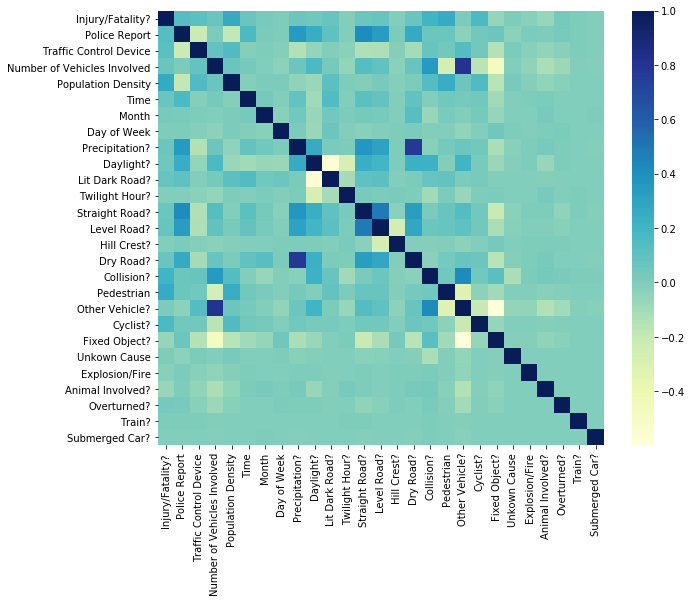

In [141]:
plt.figure(figsize = (10,8))
sns.heatmap(heat.corr(), cmap="YlGnBu");
# plt.savefig('heat_map.jpg')

1) I can possibly drop the "Other Vehicle" feature as it's covered in the "Number of Vehicles"


In [219]:
heat.columns.values

array(['Injury/Fatality?', 'Police Report', 'Traffic Control Device',
       'Number of Vehicles Involved', 'Population Density', 'Time',
       'Month', 'Day of Week', 'Precipitation?', 'Daylight?',
       'Lit Dark Road?', 'Twilight Hour?', 'Straight Road?',
       'Level Road?', 'Hill Crest?', 'Dry Road?', 'Collision?',
       'Pedestrian', 'Other Vehicle?', 'Cyclist?', 'Fixed Object?',
       'Unkown Cause', 'Explosion/Fire', 'Animal Involved?',
       'Overturned?', 'Train?', 'Submerged Car?'], dtype=object)

In [220]:
col_list = ['Injury/Fatality?', 'Police Report', 'Traffic Control Device',
       'Number of Vehicles Involved', 'Population Density', 'Time',
       'Month', 'Day of Week', 'Precipitation?', 'Daylight?',
       'Lit Dark Road?', 'Twilight Hour?', 'Straight Road?',
       'Level Road?', 'Hill Crest?', 'Dry Road?', 'Collision?',
       'Pedestrian', 'Other Vehicle?', 'Cyclist?', 'Fixed Object?',
       'Unkown Cause', 'Explosion/Fire', 'Animal Involved?',
       'Overturned?', 'Train?', 'Submerged Car?']

## 3 - Modeling

### Imports and Splitting

In [142]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score

#### Splits for Low Features

In [259]:
X, y = heat.iloc[:, 1:], heat.iloc[:, 0]

In [143]:
X_train, X_test, y_train, y_test = train_test_split(heat.iloc[:, 1:], heat.iloc[:, 0], 
                                                    test_size = 0.2, random_state=422)

In [144]:
X_train, X_val, y_train, y_val = train_test_split(X_train ,y_train, test_size=.25, random_state=422)

#### Splits for MAX features

In [280]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(df.iloc[:, 1:], heat.iloc[:, 0], 
                                                    test_size = 0.2, random_state=422)

In [281]:
X_train2, X_val2, y_train2, y_val2 = train_test_split(X_train2 ,y_train2, test_size=.25, random_state=422)

### 3.1 - "Dumb" Model

In [145]:
def no_injury(x):
    array = len(x) * [0]
    return np.array(array)

In [146]:
dumb_pred = no_injury(X_val)
dumb_confusion = confusion_matrix(y_val,dumb_pred)
dumb_score = accuracy_score(y_val,dumb_pred)
dumb_score

0.6038370297428552

Text(0.5, 1, 'All "No Injury" Confusion Matrix')

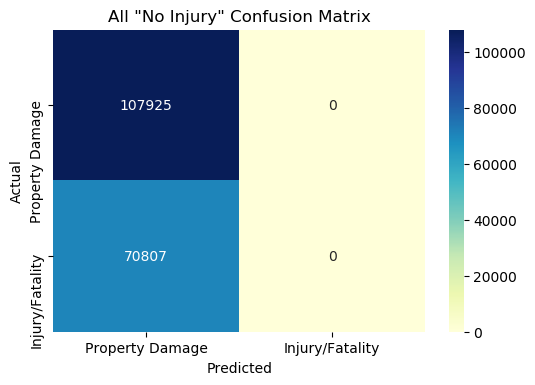

In [147]:
plt.figure(dpi=100)
sns.heatmap(dumb_confusion, cmap="YlGnBu", annot=True, fmt='g',
       xticklabels=['Property Damage', 'Injury/Fatality'],
       yticklabels=['Property Damage', 'Injury/Fatality'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('All "No Injury" Confusion Matrix')

### 3.2 - Logistic Reg

In [148]:
lm1 = LogisticRegression(C=1000, max_iter=1000)
lm1.fit(X_train, y_train)

LogisticRegression(C=1000, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [149]:
y_predict = lm1.predict(X_val)

In [150]:
accuracy_score(y_val,y_predict)

0.6722635006602063

In [151]:
lm1.score(X_train, y_train) 

0.6724518969848543

#### .30 Threshold

In [201]:
y_pred_thresh = (lm1.predict_proba(X_val)[:,1] >= 0.30).astype(bool)

In [202]:
accuracy_score(y_val,y_pred_thresh)

0.44392162567419374

In [203]:
y_pred_thresh = (lm1.predict_proba(X_val)[:,1] >= 0.30).astype(bool)

print(f' The accuracy score is {accuracy_score(y_val,y_pred_thresh)}')

recallscore = recall_score(y_val,y_pred_thresh)
pscore = precision_score(y_val, y_pred_thresh)
fscore = f1_score(y_val, y_pred_thresh)

print(f'The recall score is {recallscore}.')
print(f'The precision score is {pscore}.')
print(f'The f1 score is {fscore}.')

The recall score is 0.9034982416992671.
The precision score is 0.4087012074362742.
The f1 score is 0.5628120367560054.


#### Normal Thresh

In [152]:
recallscore = recall_score(y_val,y_predict)
pscore = precision_score(y_val, y_predict)
fscore = f1_score(y_val, y_predict)

print(f'The recall score is {recallscore}.')
print(f'The precision score is {pscore}.')
print(f'The f1 score is {fscore}.')

The recall score is 0.3115652407247871.
The precision score is 0.6917408754546595.
The f1 score is 0.4296244364599461.


In [153]:
confusion = confusion_matrix(y_test,y_predict)

Text(0.5, 1, 'Log Reg Confusion Matrix')

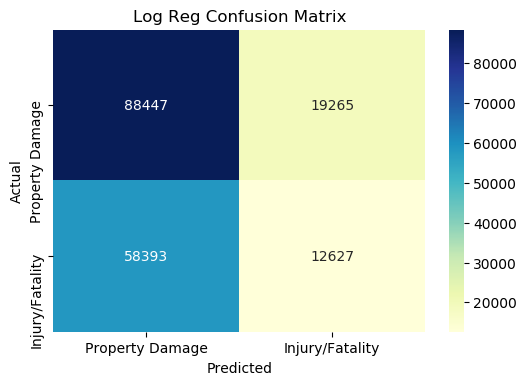

In [154]:
plt.figure(dpi=100)
sns.heatmap(confusion, cmap='YlGnBu', annot=True, fmt='g',
       xticklabels=['Property Damage', 'Injury/Fatality'],
       yticklabels=['Property Damage', 'Injury/Fatality'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Log Reg Confusion Matrix')

ROC AUC score =  0.6311297147106996


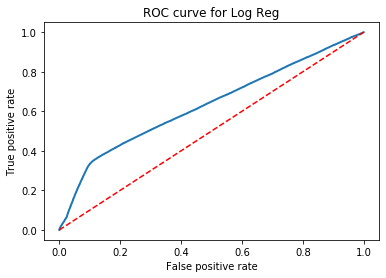

In [255]:
fpr, tpr, thresholds = roc_curve(y_val, lm1.predict_proba(X_val)[:,1])
plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='red',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve for Log Reg');
print("ROC AUC score = ", roc_auc_score(y_val, lm1.predict_proba(X_val)[:,1]))

#### Getting Coefficents

In [227]:
len(lm1.coef_)

1

In [231]:
shaved = heat.iloc[:,1:]

In [233]:
shaved.columns.values

array(['Police Report', 'Traffic Control Device',
       'Number of Vehicles Involved', 'Population Density', 'Time',
       'Month', 'Day of Week', 'Precipitation?', 'Daylight?',
       'Lit Dark Road?', 'Twilight Hour?', 'Straight Road?',
       'Level Road?', 'Hill Crest?', 'Dry Road?', 'Collision?',
       'Pedestrian', 'Other Vehicle?', 'Cyclist?', 'Fixed Object?',
       'Unkown Cause', 'Explosion/Fire', 'Animal Involved?',
       'Overturned?', 'Train?', 'Submerged Car?'], dtype=object)

In [241]:
new = np.array(['Police Report Made', 'Traffic Control Device Present',
       'Number of Vehicles Involved', 'Population Density', 'Time',
       'Month', 'Day of Week', 'Precipitation?', 'Daylight?',
       'Lit Dark Road', 'Twilight Hour?', 'Straight Road?',
       'Level Road', 'Hill Crest?', 'Dry Road?', 'Collision?',
       'Pedestrian Involved', 'Other Vehicle?', 'Cyclist Involved', 'Fixed Object?',
       'Unkown Cause', 'Explosion/Fire', 'Animal Involved?',
       'Overturned?', 'Train?', 'Submerged Car?'], dtype=object)

In [229]:
lm1.coef_

array([[ 1.78094498e-02,  1.16822815e-02, -3.85772977e-02,
         3.37486455e-05,  1.08904052e-03, -2.10358413e-02,
        -1.06533486e-01, -4.81500580e-03,  1.29053286e-04,
         1.12458319e-02, -3.83293466e-03, -7.96537170e-03,
        -2.49807943e-03, -4.63032864e-04,  3.54119763e-03,
        -1.95771993e-03,  3.00555369e-02, -2.68772916e-02,
         1.28635088e-02, -1.26291951e-02, -1.71686282e-04,
        -5.19174520e-04, -4.23587106e-03,  1.87969475e-03,
         1.15646862e-05, -4.13409424e-05]])

In [228]:
len(heat.columns.values)

27

In [239]:
logReg_coeff = pd.DataFrame({'feature_name': new, 'model_coefficient': lm1.coef_.transpose().flatten()})

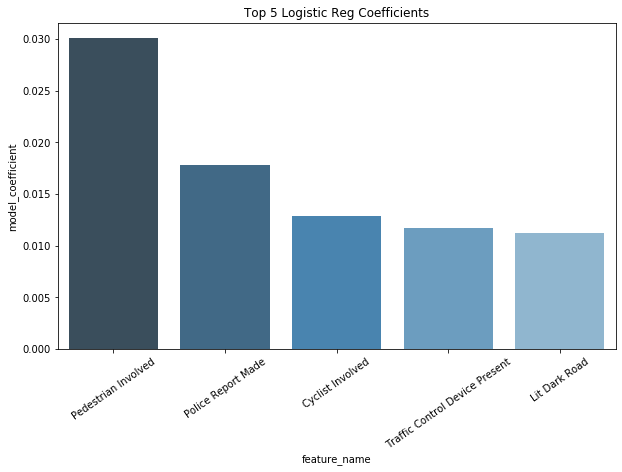

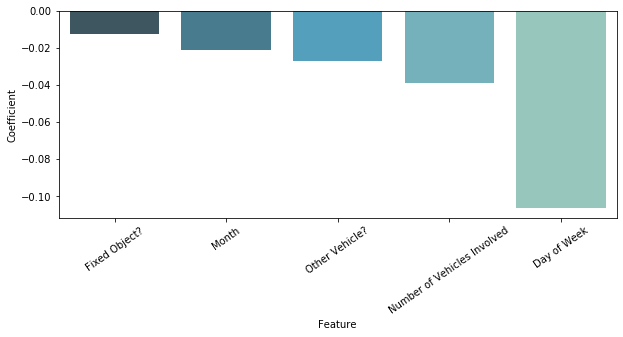

In [252]:
# Get the models coefficients (and top 5 and bottom 5)
logReg_coeff = pd.DataFrame({'feature_name': new, 'model_coefficient': lm1.coef_.transpose().flatten()})
logReg_coeff = logReg_coeff.sort_values('model_coefficient',ascending=False)
logReg_coeff_top = logReg_coeff.head(5)
logReg_coeff_bottom = logReg_coeff.tail(5)
# Plot top 5 coefficients
plt.figure().set_size_inches(10, 6)
fg3 = sns.barplot(x='feature_name', y='model_coefficient',data=logReg_coeff_top, palette="Blues_d")
fg3.set_xticklabels(rotation=35, labels=logReg_coeff_top.feature_name)
plt.title('Top 5 Logistic Reg Coefficients')
plt.savefig('top_coefficents.jpg')
# Plot bottom 5 coefficients
plt.figure().set_size_inches(10,6)
fg4 = sns.barplot(x='feature_name', y='model_coefficient',data=logReg_coeff_bottom, palette="GnBu_d")
fg4.set_xticklabels(rotation=35, labels=logReg_coeff_bottom.feature_name)
plt.xlabel('Feature')
plt.ylabel('Coefficient')
plt.subplots_adjust(bottom=0.4)
plt.savefig('figure_4.png')

### 3.3 - KNN

In [155]:
from sklearn.neighbors import KNeighborsClassifier

Let's just stick to 10 and call it a day.

In [156]:
kneighbors = KNeighborsClassifier(n_neighbors=10)
knn_model = kneighbors.fit(X_train,y_train)
knn_y_pred = knn_model.predict(X_val)
knn_score = accuracy_score(y_val,knn_y_pred)

In [157]:
knn_score = accuracy_score(y_val,knn_y_pred)

In [158]:
knn_score

0.695219658483092

In [159]:
recallscore = recall_score(y_val,knn_y_pred)
pscore = precision_score(y_val, knn_y_pred)
fscore = f1_score(y_val, knn_y_pred)

print(f'The recall score is {recallscore}.')
print(f'The precision score is {pscore}.')
print(f'The f1 score is {fscore}.')

The recall score is 0.426864575536317.
The precision score is 0.6851100482807081.
The f1 score is 0.525999791166336.


In [160]:
knn_confusion = confusion_matrix(y_val,knn_y_pred)

Text(0.5, 1, 'KNN Confusion Matrix')

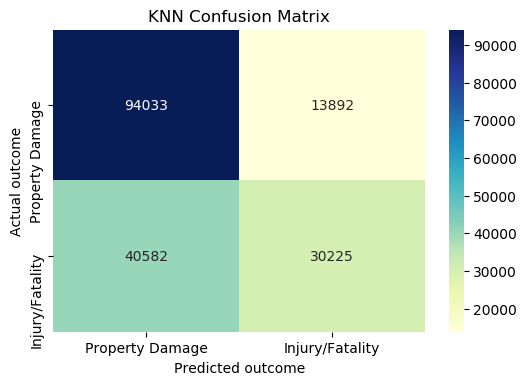

In [161]:
plt.figure(dpi=100)
sns.heatmap(knn_confusion, cmap='YlGnBu', annot=True, fmt='g',
       xticklabels=['Property Damage', 'Injury/Fatality'],
       yticklabels=['Property Damage', 'Injury/Fatality'])
plt.xlabel('Predicted outcome')
plt.ylabel('Actual outcome')
plt.title('KNN Confusion Matrix')

ROC AUC score =  0.7152376835387397


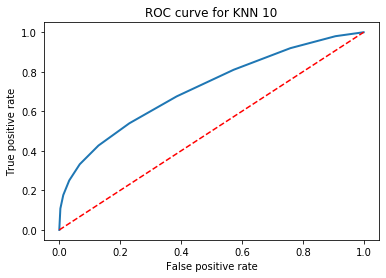

In [182]:
fpr, tpr, thresholds = roc_curve(y_val, knn_model.predict_proba(X_val)[:,1])
plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='red',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve for KNN 10');
print("ROC AUC score = ", roc_auc_score(y_val, knn_model.predict_proba(X_val)[:,1]))

### 3.4 - Decision Tree 

In [162]:
from sklearn.tree import DecisionTreeClassifier

In [163]:
tree = DecisionTreeClassifier()
tree.fit(X_train, y_train)
tree.score(X_train, y_train)

0.9053232697927799

In [164]:
tree.score(X_val, y_val)

0.6578228856612134

#### .3 Thresh

In [208]:
y_pred_thresh = (tree.predict_proba(X_val)[:,1] >= 0.30).astype(bool)

print(f'The accuracy score is {accuracy_score(y_val,y_pred_thresh)}')

recallscore = recall_score(y_val,y_pred_thresh)
pscore = precision_score(y_val, y_pred_thresh)
fscore = f1_score(y_val, y_pred_thresh)

print(f'The recall score is {recallscore}.')
print(f'The precision score is {pscore}.')
print(f'The f1 score is {fscore}.')

The accuracy score is 0.6322147125304926
The recall score is 0.640671120086997.
The precision score is 0.529606799290184.
The f1 score is 0.5798687229568651.


#### Normal Thresh

In [165]:
tree_pred = tree.predict(X_val)
recallscore = recall_score(y_val,tree_pred)
pscore = precision_score(y_val, tree_pred)
fscore = f1_score(y_val, tree_pred)

print(f'The recall score is {recallscore}.')
print(f'The precision score is {pscore}.')
print(f'The f1 score is {fscore}.')

The recall score is 0.5181408617792026.
The precision score is 0.5757057448177382.
The f1 score is 0.5454085955966521.


In [166]:
tree_confusion = confusion_matrix(y_val,tree_pred)

Text(0.5, 1, 'Decision Tree Confusion Matrix')

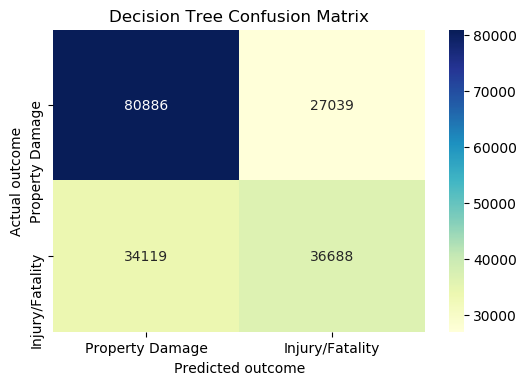

In [167]:
plt.figure(dpi=100)
sns.heatmap(tree_confusion, cmap='YlGnBu', annot=True, fmt='g',
       xticklabels=['Property Damage', 'Injury/Fatality'],
       yticklabels=['Property Damage', 'Injury/Fatality'])
plt.xlabel('Predicted outcome')
plt.ylabel('Actual outcome')
plt.title('Decision Tree Confusion Matrix')

ROC AUC score =  0.6544977309947504


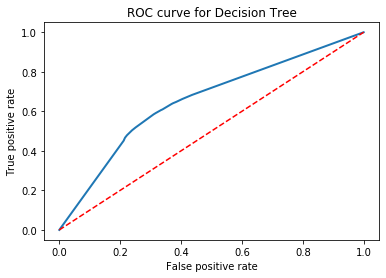

In [185]:
fpr, tpr, thresholds = roc_curve(y_val, tree.predict_proba(X_val)[:,1])
plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='red',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve for Decision Tree');
print("ROC AUC score = ", roc_auc_score(y_val, tree.predict_proba(X_val)[:,1]))

### 3.5 - Random Forest

In [168]:
from sklearn.ensemble import RandomForestClassifier

In [169]:
r_forest = RandomForestClassifier(n_estimators=100, oob_score=True, max_depth=15)
r_forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=15, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=True, random_state=None,
                       verbose=0, warm_start=False)

In [170]:
r_forest.score(X_train, y_train)

0.7392972306613477

In [171]:
r_pred = r_forest.predict(X_val)

In [172]:
r_forest.score(X_val, y_val)

0.730591052525569

#### Changing Thresholds

In [291]:
y_pred_thresh = (r_forest.predict_proba(X_val)[:,1] >= 0.35).astype(bool)

print(f' The accuracy score is {accuracy_score(y_val,y_pred_thresh)}')

recallscore = recall_score(y_val,y_pred_thresh)
pscore = precision_score(y_val, y_pred_thresh)
fscore = f1_score(y_val, y_pred_thresh)

print(f'The recall score is {recallscore}.')
print(f'The precision score is {pscore}.')
print(f'The f1 score is {fscore}.')

 The accuracy score is 0.6849584853299913
The recall score is 0.726849040349118.
The precision score is 0.5819773161602569.
The f1 score is 0.6463953780457171.


In [292]:
thresh_confusion = confusion_matrix(y_val,y_pred_thresh)

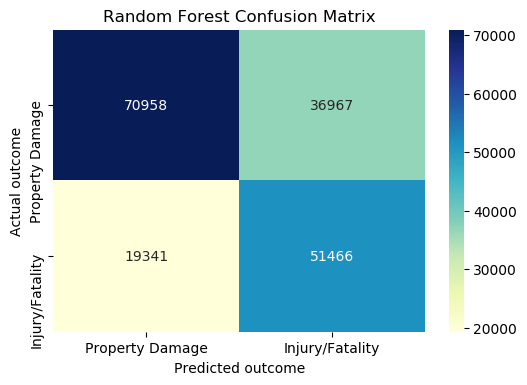

In [290]:
plt.figure(dpi=100)
sns.heatmap(thresh_confusion, cmap='YlGnBu', annot=True, fmt='g',
       xticklabels=['Property Damage', 'Injury/Fatality'],
       yticklabels=['Property Damage', 'Injury/Fatality'])
plt.xlabel('Predicted outcome')
plt.ylabel('Actual outcome')
plt.title('Random Forest Confusion Matrix')
plt.savefig('random_forest_matrix.jpg')


#### Testing for final

In [294]:
y_pred_test = (r_forest.predict_proba(X_test)[:,1] >= 0.35).astype(bool)

print(f' The accuracy score is {accuracy_score(y_test,y_pred_test)}')

recallscore = recall_score(y_test,y_pred_test)
pscore = precision_score(y_test, y_pred_test)
fscore = f1_score(y_test, y_pred_test)

print(f'The recall score is {recallscore}.')
print(f'The precision score is {pscore}.')
print(f'The f1 score is {fscore}.')

 The accuracy score is 0.6855683369514133
The recall score is 0.7263587721768516.
The precision score is 0.5838756776946498.
The f1 score is 0.6473699732071707.


#### Normal - .50 thresh

In [173]:
recallscore = recall_score(y_val,r_pred)
pscore = precision_score(y_val, r_pred)
fscore = f1_score(y_val, r_pred)

print(f'The recall score is {recallscore}.')
print(f'The precision score is {pscore}.')
print(f'The f1 score is {fscore}.')

The recall score is 0.46820229638312594.
The precision score is 0.7595133909138811.
The f1 score is 0.5792968476969315.


In [174]:
r_confusion = confusion_matrix(y_val,r_pred)

Text(0.5, 1, 'Random Forest Confusion Matrix')

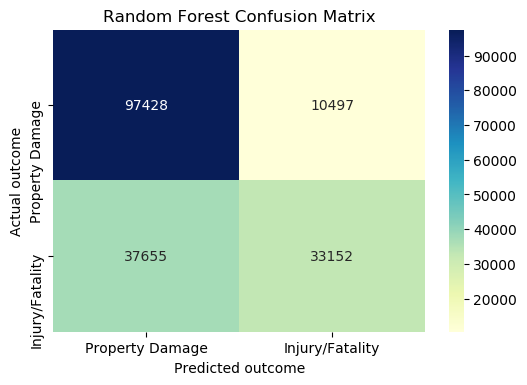

In [175]:
plt.figure(dpi=100)
sns.heatmap(r_confusion, cmap='YlGnBu', annot=True, fmt='g',
       xticklabels=['Property Damage', 'Injury/Fatality'],
       yticklabels=['Property Damage', 'Injury/Fatality'])
plt.xlabel('Predicted outcome')
plt.ylabel('Actual outcome')
plt.title('Random Forest Confusion Matrix')

ROC AUC score =  0.7828769695189368


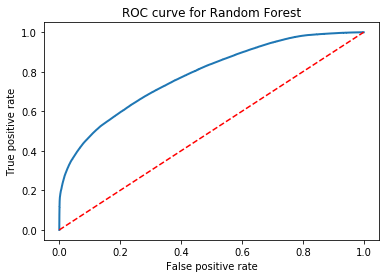

In [186]:
fpr, tpr, thresholds = roc_curve(y_val, r_forest.predict_proba(X_val)[:,1])
plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='red',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve for Random Forest');
print("ROC AUC score = ", roc_auc_score(y_val, r_forest.predict_proba(X_val)[:,1]))

### Gradient Boost

In [256]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [260]:
data_matrix = xgb.DMatrix(data=X,label=y)

In [283]:
gbm = xgb.XGBClassifier( 
                        n_estimators=30000,
                        max_depth=60,
                        objective='binary:logistic', #new objective
                        learning_rate=.1, 
                        subsample=1,
                        min_child_weight=3,
                        colsample_bytree=.8
                       )

eval_set=[(X_train2,y_train2),(X_val2,y_val2)]
fit_model = gbm.fit( 
                    X_train2, y_train2, 
                    eval_set=eval_set,
                    eval_metric='error', #new evaluation metric: classification error (could also use AUC, e.g.)
                    early_stopping_rounds=25,
                    verbose=False)

In [284]:
print('done!')

done!


In [285]:
accuracy_score(y_test2, gbm.predict(X_test2, ntree_limit=gbm.best_ntree_limit))


0.7234518720766286

In [287]:
y_pred_x = gbm.predict(X_val2, ntree_limit=gbm.best_ntree_limit)

recallscore = recall_score(y_val2,y_pred_x)
pscore = precision_score(y_val2, y_pred_x)
fscore = f1_score(y_val2, y_pred_x)

print(f'The accuracy score is {accuracy_score(y_val2,y_pred_x)}')
print(f'The recall score is {recallscore}.')
print(f'The precision score is {pscore}.')
print(f'The f1 score is {fscore}.')

The accuracy score is 0.7235078217666674
The recall score is 0.49180165802816106.
The precision score is 0.7216155169198251.
The f1 score is 0.5849459114425856.


In [288]:
xgb_confusion = confusion_matrix(y_val2,y_pred_x)

Text(0.5, 1, 'XG Boost Confusion Matrix')

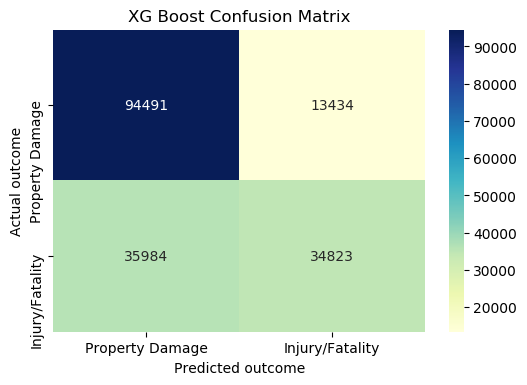

In [289]:
plt.figure(dpi=100)
sns.heatmap(xgb_confusion, cmap='YlGnBu', annot=True, fmt='g',
       xticklabels=['Property Damage', 'Injury/Fatality'],
       yticklabels=['Property Damage', 'Injury/Fatality'])
plt.xlabel('Predicted outcome')
plt.ylabel('Actual outcome')
plt.title('XG Boost Confusion Matrix')